In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',
                header=None)

In [13]:
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values # 30 features
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y) # transform class labels form string represejtation onto integers

In [14]:
# (M=malignant=1, B=benign=0)
le.transform(['M', 'B'])

array([1, 0])

In [15]:
# divide dataset into training dataset (80 %) and test dataset (80%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.20, random_state=1)

In [16]:
# pipeline takes list of tuples as input, first value arbitrry identifier string, second element is scikit-learn
# transformer or estimator
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
pipe_lr = Pipeline([('scl', StandardScaler()),
                ('pca', PCA(n_components=2)), # reduce to 2-D
                ('clf', LogisticRegression(random_state=1))])
pipe_lr.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test Accuracy: 0.947


In [18]:
# k-fold cross-validation to assess model performance

# holdout cross-validation
# separate data into three parts: training set, validation set and a test set
# training set used to fit different models, 
# validation set is used for model selection (tuning parameters / hyperparameters)
# test set used for evaluating model's generalization error
# Drawback: performance estimate is sensitive to how we partition training and validation subsets

# k-fold cross-validation
# randomly split training dataset into k folds without replacement where k-1 folds are used for the model training and
# one fold use for testing. Repeat k times to obtain k models and performance estimates.
# Standard value for k is 10.

# Stratified cross-validation, class proportions are preserved in each fold (representative of class proportions in 
# training set)
# can yield better bias and variance estimates, esp in cases of unequal class proportions

import numpy as np
from sklearn.cross_validation import StratifiedKFold
kfold = StratifiedKFold(y=y_train,
                       n_folds=10,
                       random_state=1)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [19]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


In [20]:
# scikit-learn k-fold cross-validation scorer
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                        X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1) # no. of cpus, -1 to use all available
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [ 0.89130435  0.97826087  0.97826087  0.91304348  0.93478261  0.97777778
  0.93333333  0.95555556  0.97777778  0.95555556]


In [21]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


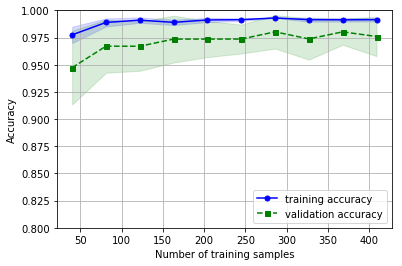

In [26]:
# Debuging algorithms with learning and validation curves

# Diagnosing bias and variance problems with learning curves
# Plot model training and validation accuracies as functions of training set size 
# to detect high variance or high bias

# Evaluate model using learning curve function from scikit-learn
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
%matplotlib inline

pipe_lr = Pipeline([
        ('scl', StandardScaler()),
        ('clf', LogisticRegression(
            penalty='l2', random_state=0))])
train_sizes, train_scores, test_scores =\
    learning_curve(estimator=pipe_lr,
                   X=X_train,
                  y=y_train,
                  train_sizes=np.linspace(0.1, 1.0, 10),
                  cv=10,
                  n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean,
        color='blue', marker='o',
        markersize=5,
        label='training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--',
        marker='s', markersize=5, label='validation accuracy')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()